In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import math
import os

import pytesseract
from pytesseract import Output
from sklearn.cluster import KMeans
from random import randint

In [2]:
# Helper functions

# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((3,3),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45 :
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

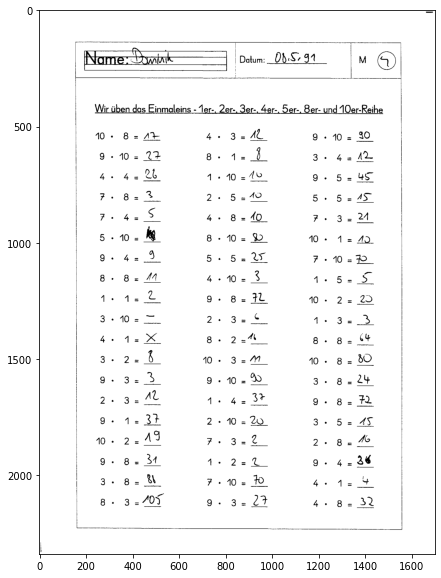

In [3]:
# Read and preprocess image

#image = cv2.imread('testImages/testImage1.jpg')
image = cv2.imread('testImages/testImage2.jpg')
#image = cv2.imread('testImages/testImage3.jpg')
imageCopy = image.copy()


image = get_grayscale(image)
image = thresholding(image)
plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray')

Number of found bounding boxes:  56


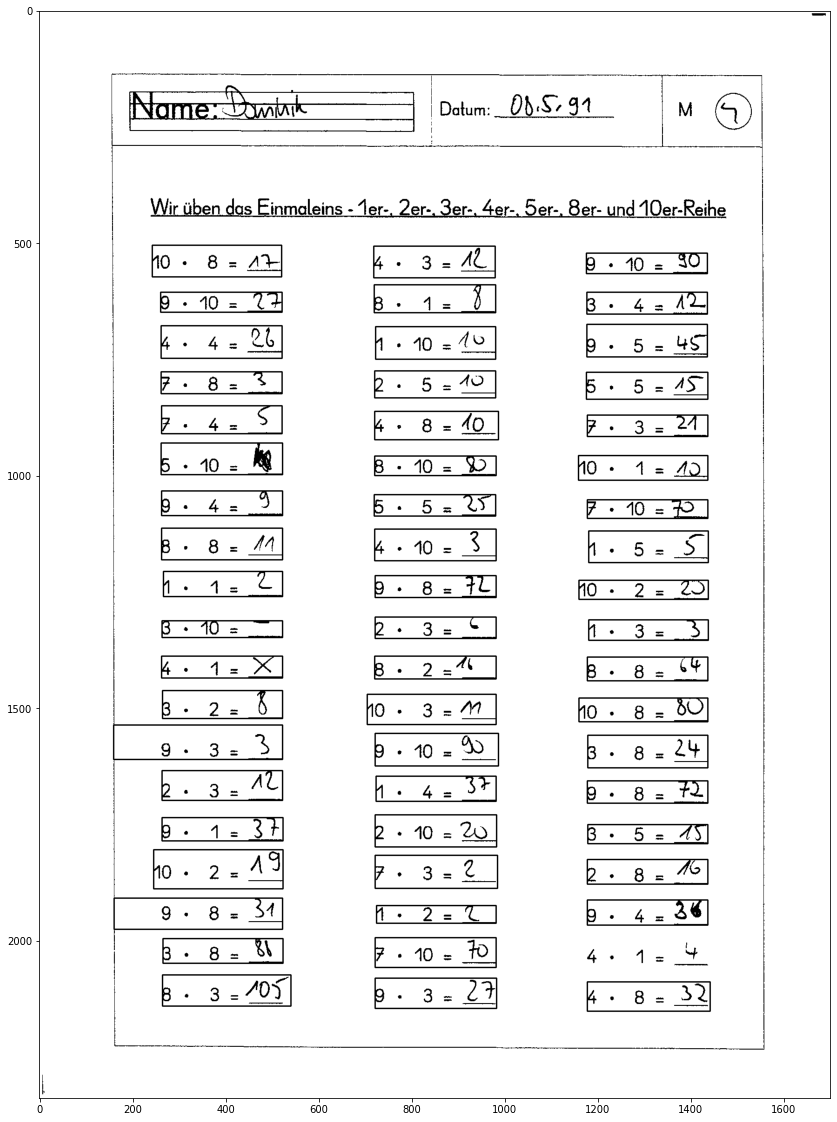

In [4]:
# Select preprocessed image and apply tesseract OCR 

img = image
custom_config = r'--oem 3 --psm 6 outputbase digits'
widthMax = 1000
heightMax = 1000
ratioMax =  1/10
areaMax = 1000*300
areaMin = 10*50

d = pytesseract.image_to_data(img, config=custom_config, output_type=Output.DICT)
n_boxes = len(d['level'])
boxList = []
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    #Check if the absolute lenght or hight is too high
    #Check if the ratio is too high
    #Check if the area is too high
    if (w < widthMax and h < heightMax and (h/w) > ratioMax and (h*w) > areaMin):
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        boxList.append((x, y, x + w, y + h))

# Plot results
print("Number of found bounding boxes: ", len(boxList))
plt.figure(figsize=(20,20))
plt.imshow(img, cmap = 'gray')

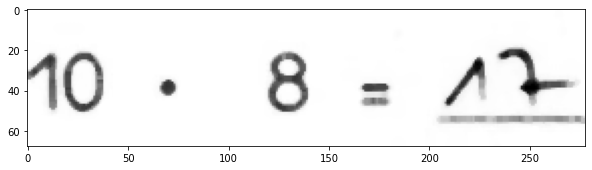

In [5]:
# Apply sublevel OCR to all found boxes

n = 0

# Extract box dimensions 
a = boxList[n][0]
b = boxList[n][1]
c = boxList[n][2]
d = boxList[n][3]
subImg = imageCopy[b:d,a:c]

# Create image copy for drawing
subImgCopy = subImg.copy()

# Preprocessing
subImg = get_grayscale(subImg)
subImg = remove_noise(subImg)
#subImg = thresholding(subImg) 
#subImg = subImg / 255.0
#subImg = opening(subImg)
#subImg = canny(subImg)
#subImg = dilate(subImg)

# Plot bounding box
plt.figure(figsize=(10,10))
plt.imshow(subImg, cmap='gray')

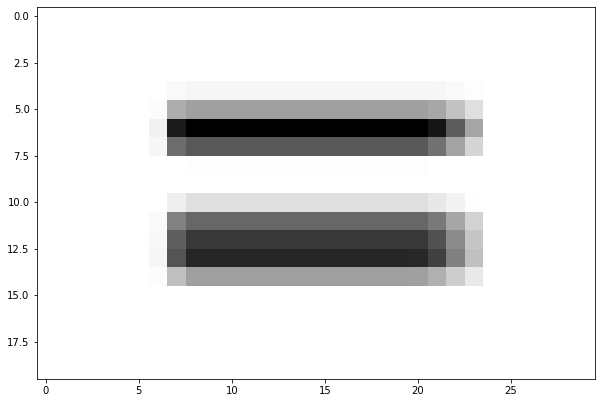

In [6]:
# Understand equation by finding equal sign

# Read and preprocess template
template = cv2.imread('testImages/equalSignTemplate.jpg')
template = get_grayscale(template)
length = template.shape[1]
width = template.shape[0]

# Resize template 
templateScale1 = cv2.resize(template, (15, 10))
templateScale2 = cv2.resize(template, (30, 20))
templateScale3 = cv2.resize(template, (60, 30))
templateScale4 = cv2.resize(template, (120, 60))

# Select template
tmpl = templateScale2

# Plot templates
plt.figure(figsize=(10,10))
plt.imshow(tmpl, cmap='gray')

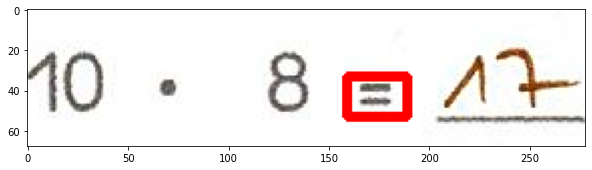

In [7]:
# Template matching 
match = match_template(subImg, tmpl)

# Get highes likelihood box
_minVal, _maxVal, minLoc, maxLoc = cv2.minMaxLoc(match, None)
xMax = maxLoc[0]
yMax = maxLoc[1]
H, W = tmpl.shape[:2]
boxMax = (xMax, yMax, xMax + W, yMax + H)

# Print most likely matching box only 
drawLikelyMatchOnImage = cv2.rectangle(subImgCopy, (boxMax[0], boxMax[1]), (boxMax[2], boxMax[3]), (255, 0, 0), 3)

# Plot results
plt.figure(figsize=(10,10))
plt.imshow(subImgCopy)

In [8]:
print("Best matching rectangle: ", boxMax)
print("The match certainly is: ", _maxVal)

Best matching rectangle:  (159, 33, 189, 53)
The match certainly is:  0.7723206877708435


In [9]:
# TODO:
# Apply different Template scales and use the most likely match

In [10]:
# TODO: 
# Use equality box to split up the equation into left side and right side 